# Problem Set 8

**Mingqi Sui, Diana Zhang, Tong Liu, Valentina Cortés, Edoardo Pettinato**

**Group 9 - Cohort 1**

## Problem 1

### Part(a）

In [4]:
import os
os.chdir(r"C:\Users\76721\Desktop\UCLA\Fall-2024\Investments\Lecture 7")
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce
import quadprog as QD
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Prepare data
#load data 
#stock data
df_list = []
for i in range(0,5):
    df = pd.read_excel('lecture6p_2022.xlsx', sheet_name = i)
    #new_df = function(df)
    df_list.append(df)

#load Fama French data
ff = pd.read_excel('lecture6p_2022.xlsx', sheet_name = "F-F_Research_Data_Factors_daily")

begindate = "1989-12-29"
enddate = "2022-08-31"
def cleandt(d):
    d.columns = d.columns.str.lower()
    filt = (d['date'] >= begindate) & (d['date'] <= enddate)
    d = d.loc[filt]
    d = d[["date","adjclose"]]
    return d

df_list_new = [cleandt(d) for d in df_list]

df_list_new[0] = df_list_new[0].rename(columns = { "adjclose":"MSFT"})
df_list_new[1] = df_list_new[1].rename(columns = { "adjclose":"INTC"})
df_list_new[2] = df_list_new[2].rename(columns = { "adjclose":"LUV"})
df_list_new[3] = df_list_new[3].rename(columns = { "adjclose":"MCD"})
df_list_new[4] = df_list_new[4].rename(columns = { "adjclose":"JNJ"})

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), df_list_new)

# clean fama french data 
ff.columns = ff.columns.str.lower()
ff = ff[["date", "mktrf", "rf"]]
ff["rf"] = ff["rf"]/100
ff["mktrf"] = ff["mktrf"]/100
ff['rfleveladj'] = (ff['rf']+1).cumprod()
ff["mktrfleveladj"] = (ff['mktrf']+1).cumprod()
filt = (ff['date'] >= begindate) & (ff['date'] <= enddate)
ff = ff.loc[filt]

d = pd.merge(ff, df_merged, how="inner", on=["date"])
#print(d)
d['Date'] = d['date']
d = d.set_index('date')
d = d.resample('W-Fri').last()
#print(d)

d['rf'] = (d['rfleveladj']/d['rfleveladj'].shift() -1)  ##### May need to recheck
d['mktrf'] = (d['mktrfleveladj']/d['mktrfleveladj'].shift() -1)#recreate the excess market return
d['MSFT'] = (d['MSFT']/d['MSFT'].shift() -1)
d['INTC'] = (d['INTC']/d['INTC'].shift() -1)
d['LUV'] = (d['LUV']/d['LUV'].shift() -1)
d['MCD'] = (d['MCD']/d['MCD'].shift() -1)
d['JNJ'] = (d['JNJ']/d['JNJ'].shift() -1)
#print(d)
d= d.dropna()


In [6]:
dftable = d.iloc[:,4:9] #select all stocks 


#standard deviation
res = dftable.agg([np.mean,np.std])
res*100



,MSFT,INTC,LUV,MCD,JNJ
mean,0.465523,0.348689,0.328648,0.281898,0.263134
std,4.055892,4.881337,4.766215,3.089981,2.811242


In [7]:
MSFTminusRF = d['MSFT'] - d['rf']
MktRF = d['mktrf']

# adding a constant
MktRF = sm.add_constant(MktRF)
model = sm.OLS(MSFTminusRF, MktRF).fit()
modelrss = model.resid.std(ddof=MktRF.shape[1]) #model residual standard error
# Printing model summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     852.2
Date:                Sat, 30 Nov 2024   Prob (F-statistic):          2.99e-152
Time:                        23:49:40   Log-Likelihood:                 3392.3
No. Observations:                1705   AIC:                            -6781.
Df Residuals:                    1703   BIC:                            -6770.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.193      0.001       0.001       0.004
mktrf          0.9845      0.034     29.193      0.000       0.918       1.051
==============================================================================
Omnibus:                      201.079   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1239.262
Skew:                           0.359   Prob(JB):                    7.90e-270
Kurtosis:                       7.114   Cond. No.                         42.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Calculate excess returns for each stock
stocks = ['MSFT', 'INTC', 'LUV', 'MCD', 'JNJ']
excess_returns = {stock: d[stock] - d['rf'] for stock in stocks}

# Prepare the independent variable (market excess returns) with a constant
MktRF = sm.add_constant(d['mktrf'])

# Initialize a DataFrame to store results
results = []

# Perform regression for each stock
for stock, excess_return in excess_returns.items():
    #print(stock, type(excess_return))
    model = sm.OLS(excess_return, MktRF).fit()
    beta = model.params['mktrf']
    std_error = model.bse['mktrf']
    results.append({'Stock': stock, 'Beta': beta, 'Std Error': std_error})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,Stock,Beta,Std Error
0,MSFT,0.984480,0.033723
1,INTC,1.167792,0.040886
2,LUV,1.062415,0.041171
3,MCD,0.639058,0.027417
4,JNJ,0.553550,0.025291


In [9]:
results = []
# Perform regression for each stock
for stock, excess_return in excess_returns.items():
    model = sm.OLS(excess_return, MktRF).fit()
    alpha = model.params['const']
    alpha_std_error = model.bse['const']
    beta = model.params['mktrf']
    beta_std_error = model.bse['mktrf']
    idiosyncratic_std = model.resid.std(ddof = MktRF.shape[1]) # standard errors of residuals
    print(MktRF.shape)
    results.append({'Stock': stock, 'Alpha': alpha, 'Alpha std Error': alpha_std_error,'Beta': beta, 
                    'Beta std Error': beta_std_error,'Idiosyncratic Std Dev': idiosyncratic_std})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

(1705, 2)
(1705, 2)
(1705, 2)
(1705, 2)
(1705, 2)


,Stock,Alpha,Alpha std Error,Beta,Beta std Error,Idiosyncratic Std Dev
0,MSFT,0.002566,0.000804,0.984480,0.033723,0.033109
1,INTC,0.001098,0.000974,1.167792,0.040886,0.040142
2,LUV,0.001070,0.000981,1.062415,0.041171,0.040421
3,MCD,0.001296,0.000653,0.639058,0.027417,0.026918
4,JNJ,0.001249,0.000603,0.553550,0.025291,0.024831


### Part(c)

In [11]:
# Calculate average excess return for each stock
avg_excess_returns = {stock:excess_return.mean() for stock, excess_return in excess_returns.items()}

# Calculate average excess return for market portfolio
average_market_excess_return = d['mktrf'].mean()

# Compute the CAPM estimated return and compare it with Sample average excess return 
comparison_results = []

for result in results:
    stock = result['Stock']
    beta = result['Beta']
    predicted_return = beta * average_market_excess_return
    actual_return = avg_excess_returns[stock]
    diff = actual_return - predicted_return
    comparison_results.append({'Stock':stock,
                              'Sample average excess return':actual_return,
                              'CAPM predicted return':predicted_return,
                              'Diff(Actual - CAPM predicted)':diff})
comparison_df = pd.DataFrame(comparison_results)
comparison_df

,Stock,Sample average excess return,CAPM predicted return,Diff(Actual - CAPM predicted)
0,MSFT,0.004179,0.001613,0.002566
1,INTC,0.003011,0.001914,0.001098
2,LUV,0.002811,0.001741,0.001070
3,MCD,0.002343,0.001047,0.001296
4,JNJ,0.002156,0.000907,0.001249


## Problem 2

### Part(a)

In [14]:
beta = 1.3
rf = 0.009
mktrp = 0.04
B_return_CAPM  = beta * mktrp + rf
print("According to the CAPM, investors should expect the return of security is {:.5f}.".format(B_return_CAPM))

According to the CAPM, investors should expect the return of security is 0.06100.


### Part(b)

In [16]:
price = 50
expected_price = price * (1 + B_return_CAPM)
print("Given no dividend,The security should be traded at the price of {:.5f} next year".format(expected_price))

Given no dividend,The security should be traded at the price of 53.05000 next year


### Part(c)

In [18]:
dividend = 2
print("Given dividend is $2, the security should be traded at the price of {:.5f}".format(expected_price - dividend)) 

Given dividend is $2, the security should be traded at the price of 51.05000


## Problem 3

### Part(a)

In [21]:
# Store return into vector
Danger_return = [-0.19,0.2]
Steady_return = [-0.01,0.075]
mkt_return = [-0.08,0.12]

# Calcualte covarince of two companies with the market
cov_Danger_mkt = np.cov(Danger_return,mkt_return, ddof = 0)[0,1]
cov_Steady_mkt = np.cov(Steady_return,mkt_return,ddof = 0)[0,1]
var_market = np.cov(Danger_return,mkt_return, ddof = 0)[1,1]

beta_Danger = cov_Danger_mkt / var_market
beta_Steady = cov_Steady_mkt / var_market

print("The beta of DangerCo is {:.5f}.".format(beta_Danger))
print("The beta of SteadyCo is {:.5f}.".format(beta_Steady))

The beta of DangerCo is 1.95000.
The beta of SteadyCo is 0.42500.


### Part(b)

In [23]:
# Calculate expected return of stocks
expected_return_Danger = np.mean(Danger_return)
expected_return_Steady = np.mean(Steady_return)
print("Expected rate of return on DangerCo. is {:.5f}.".format(expected_return_Danger))
print("Expected rate of return on SteadyCo. is {:.5f}.".format(expected_return_Steady))

Expected rate of return on DangerCo. is 0.00500.
Expected rate of return on SteadyCo. is 0.03250.


### Part(c)

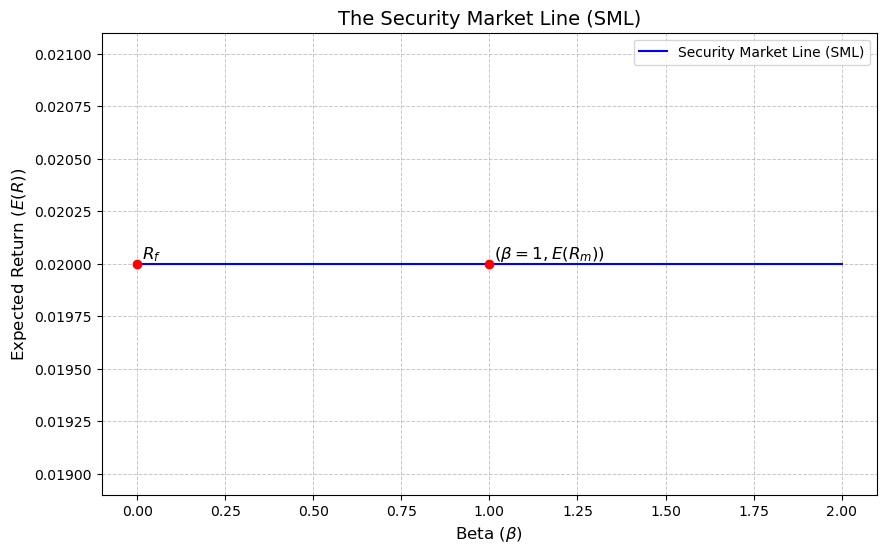

In [25]:
# Calculate slope of sml
from scipy.linalg import solve
rf = 0.02
expected_return_mkt = np.mean(mkt_return)
b = [rf, expected_return_mkt]
A = [[0,1],[1,1]]
slope = solve(A,b)[0]
sml_x = np.linspace(0,2,100)
sml_y = b[0] + sml_x * slope

#print(slope)
#print(np.mean(mkt_return) - rf)


# Draw the SML graph
plt.figure(figsize=(10, 6))
plt.plot(sml_x, sml_y, label="Security Market Line (SML)", color="blue")

# Highlight beta = 1
beta_1 = 1
expected_return_beta_1 = b[0] + beta_1 * slope

plt.scatter(beta_1, expected_return_beta_1, color="red", zorder=5)
plt.text(beta_1, expected_return_beta_1, " $(\\beta=1, E(R_m))$", fontsize=12, verticalalignment='bottom')

# Mark risk-free rate and Market portfolio
plt.scatter([0], [b[0]], color="red", zorder=5)
plt.text(0, b[0], " $R_f$", fontsize=12, verticalalignment='bottom')

# Format axes and labels
plt.xlabel("Beta ($\\beta$)", fontsize=12)
plt.ylabel("Expected Return ($E(R)$)", fontsize=12)
plt.title("The Security Market Line (SML)", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend()
plt.show()


### Part(d)

The alpha of DangerCo. is -0.01500
The alpha of SteadyCo. is 0.01250


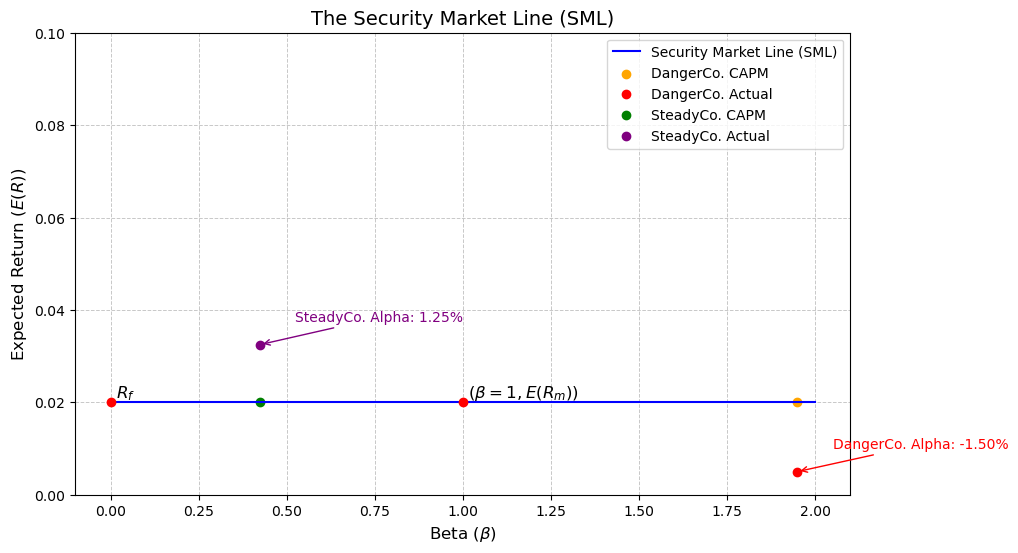

In [27]:
# Calcualte the value
capm_Danger_return = rf + slope * beta_Danger
capm_Steady_return = rf + slope * beta_Steady

# Calculate the alpha of two stocks
alpha_Danger = expected_return_Danger - capm_Danger_return
alpha_Steady = expected_return_Steady - capm_Steady_return

print("The alpha of DangerCo. is {:.5f}".format(alpha_Danger))
print("The alpha of SteadyCo. is {:.5f}".format(alpha_Steady))

# Draw the SML graph
plt.figure(figsize=(10, 6))
plt.plot(sml_x, sml_y, label="Security Market Line (SML)", color="blue")
plt.scatter(beta_Danger, capm_Danger_return, label="DangerCo. CAPM", color="orange")
plt.scatter(beta_Danger, expected_return_Danger, label="DangerCo. Actual", color="red")
plt.scatter(beta_Steady, capm_Steady_return, label="SteadyCo. CAPM", color="green")
plt.scatter(beta_Steady, expected_return_Steady, label="SteadyCo. Actual", color="purple")

# Add alpha annotations
plt.annotate(f"DangerCo. Alpha: {alpha_Danger:.2%}", 
             (beta_Danger, expected_return_Danger), 
xytext=(beta_Danger + 0.1, expected_return_Danger + 0.005), 
arrowprops=dict(arrowstyle="->", color="red"), fontsize=10, color="red")

plt.annotate(f"SteadyCo. Alpha: {alpha_Steady:.2%}", 
             (beta_Steady, expected_return_Steady), 
xytext=(beta_Steady + 0.1, expected_return_Steady + 0.005), 
arrowprops=dict(arrowstyle="->", color="purple"), fontsize=10, color="purple")

# Highlight beta = 1
beta_1 = 1
expected_return_beta_1 = rf + beta_1 * slope
plt.scatter(beta_1, expected_return_beta_1, color="red", zorder=5)
plt.text(beta_1, expected_return_beta_1, " $(\\beta=1, E(R_m))$", fontsize=12, verticalalignment='bottom')

# Mark risk-free rate and Market portfolio
plt.scatter([0], [rf], color="red", zorder=5)
plt.text(0, rf, " $R_f$", fontsize=12, verticalalignment='bottom')

# Format axes and labels
plt.ylim(0, 0.1)  # Adjust y-axis limit to make the graph larger
plt.xlabel("Beta ($\\beta$)", fontsize=12)
plt.ylabel("Expected Return ($E(R)$)", fontsize=12)
plt.title("The Security Market Line (SML)", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)
plt.legend()
plt.show()


